In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from state import get_state, queue
# from basic.reward_basic import calculate_reward
from basic.learner_basic import Learner
from traffic_lights_maps import get_traffic_light_phases, make_map
from DeeQ_reward import calculate_reward
import os
import sys

import traci
import random
import gym
from gym import spaces

In [3]:
# if traci.isLoaded():
#     traci.close()

In [4]:
from tensorflow.keras import Sequential, layers
from tensorflow.random import set_seed
import numpy as np
from collections import deque
from tensorflow import keras
from tensorflow import reduce_sum, reduce_mean, one_hot, GradientTape
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

In [ ]:
set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [36]  # == env.observation_space.shape
n_outputs = 8  # == env.action_space.n

model_action = Sequential([
    layers.Dense(1, activation="elu", input_shape=input_shape),
    # layers.Dense(2, activation="elu"),
    layers.Dense(n_outputs)
])


/Users/arseneclaustre/.pyenv/versions/3.10.6/envs/RL_traffic/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model_action.predict(state[np.newaxis], verbose=0)[0]
        print(Q_values)
        return Q_values.argmax()  # optimal action according to the DQN

In [7]:
values = np.array([0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],)
epsilon_greedy_policy(values)

[-0.42142174 -0.05376806 -0.3521004  -0.20856397 -0.09481451 -0.25162736
 -0.15416251 -0.12955697]


np.int64(1)

In [8]:
replay_buffer = deque(maxlen=2000)
len(replay_buffer)

0

In [9]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(4)
    ]
    return states, actions, rewards, next_states

In [12]:
# def play_one_step(env, state, epsilon):
#     action = epsilon_greedy_policy(state, epsilon)
#     next_state, reward= env.step(action)  # !!!!!!!!!!!!!!CHANGE
#     replay_buffer.append((state, action, reward, next_state))
#     return next_state, reward

In [13]:
batch_size = 1
discount_factor = 0.95
optimizer = keras.optimizers.Nadam(learning_rate=1e-1)
loss_fn = MeanSquaredError()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states = experiences  # a changer
    next_Q_values = model_action.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    # runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = one_hot(actions, n_outputs)
    with GradientTape() as tape:
        all_Q_values = model_action(states)
        Q_values = reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model_action.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_action.trainable_variables))

In [60]:
if traci.isLoaded():
    traci.close()

In [32]:
sumoBinary = "/Users/arseneclaustre/sumo/bin/sumo-gui"
sumoBinary2 = "/Users/arseneclaustre/sumo/bin/sumo"
sumoConfig = r"C:/Program Files/rl_project/2025-02-12-16-24-37/osm.sumocfg"
sumoConfig2 = r"C:/Program Files/rl_project/2025-02-25-19-05-44/osm.sumocfg"
# sumoConfig3 = r"/home/psels/code/psels/RL_traffic/RL_traffic/Traditional_traffic/traditional_traffic.sumo.cfg"
sumoConfig3 = r"Traditional_traffic/traditional_traffic.sumo.cfg"


rewards = []
best_score = 0
reward = 0
total_reward = 0
list_values = []
weights = []
wait_times = []
replay_buffer = deque(maxlen=2000)


sumoCmd = [sumoBinary2, "-c", sumoConfig3, "--start"]
for episode in range(5):
    if traci.isLoaded():
        traci.close()
    traci.start(sumoCmd)
    lane_ids =  traci.lane.getIDList()
    # print(lane_ids[0])

    trafic_light_ids = traci.trafficlight.getIDList()

    state = np.array(queue(lane_ids))
    # print(state)
    wait_times.append(0)
    for step in range(50000): ## TO CHANGED
        epsilon = max(1 - episode / 500, 0.01)

        if step%1000 == 0:

            ########################################################################
            ##Calcul de la reward
            next_state = np.array(queue(lane_ids))
            # reward = calculate_reward(values, reward, total_reward)[0]
            reward=np.sum(state)-np.sum(next_state)
            replay_buffer.append((state, action, reward, next_state))

            list_values.append(queue(lane_ids))
            #########################################################################
            state=next_state
            action = epsilon_greedy_policy(state, epsilon)
            print("action", action)
            traci.trafficlight.setPhase(trafic_light_ids[0],action)


            # print('phase', traci.trafficlight.getPhase(trafic_light_ids[0]))



             #next state
            # reward = get_reward(state, next_state)

            if len(replay_buffer) >= batch_size*10:
                training_step(batch_size)
                new_weights = model_action.get_weights()
                weights.append(new_weights)
                #print(f"Episode {episode}: new weights = {new_weights}")
            else:
                print(f"Episode {episode}: pas assez de données dans le replay buffer.")
            # print(values)
            print(f'list values {list_values[-1]}')

            reward = calculate_reward(values, reward, total_reward)[0] # POUR FAIRE TOURNER LE PROJET
        # print("reward",reward)

        # changement de reward pour voir


            # print("wait time", wait_time)


        traci.simulationStep()

        # obs, reward, truncated, info = play_one_step(env, obs, epsilon)    # on est parti de ça pour coder cette cellule


    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    # print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
    #       end="")
    #rewards.append(reward)  # avant c'était step mais je pense que c'est mieux avec Reward
    # if reward >= best_score:
    #     best_weights = model_action.get_weights()
    #     best_score = reward

traci.close()
model_action.set_weights(new_weights)

 Retrying in 1 seconds


action 7
Episode 0: pas assez de données dans le replay buffer.
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 6
Episode 0: pas assez de données dans le replay buffer.
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 0
Episode 0: pas assez de données dans le replay buffer.
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 7
Episode 0: pas assez de données dans le replay buffer.
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 0
Episode 0: pas assez de données dans le replay buffer.
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 3
Episode 0: pas assez de données dans le replay buffer.
list values

action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 6
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 5
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 6
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 0
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 1
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 3
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4,

action 1
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 7
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 7
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 0
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 6
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 1
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 0
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4,

list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 4
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 4
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 6
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 6
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 7
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

action 5
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 0
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 3
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 4
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 3
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 0.00 (1ms ~= 10.00*RT, ~31000.00UPS, TraCI: 33ms, vehicles TOT 33 ACT 31 BUF 0)    
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 4
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 4
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 7
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 4
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 7
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 7
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 3
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0,

action 4
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 6
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 1
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 6
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 4
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 7.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 33 ACT 31 BUF 0)                    
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 1
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 3
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 3
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 3
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 5
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
action 2
list values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
wait_times

[0, 0, 0, 0, 0]

In [34]:
before = weights[0][0]
before

array([[ 2.1592700e-01],
       [ 1.6181600e-01],
       [ 3.1433076e-02],
       [-2.4746850e-01],
       [ 2.2025186e-01],
       [-1.7618960e-01],
       [-1.2819803e-01],
       [ 9.0473533e-02],
       [-1.7090590e-01],
       [-3.3681920e-01],
       [ 6.0917258e-02],
       [-2.2765268e-01],
       [-2.3183563e-01],
       [ 1.2587172e+01],
       [ 1.8982260e+01],
       [-3.7309289e-01],
       [ 2.2420437e+01],
       [ 2.7347328e+01],
       [-2.4662736e-01],
       [ 2.9165894e-01],
       [ 1.6126305e-01],
       [ 3.7667722e-01],
       [ 1.6193140e+01],
       [ 2.2070538e+01],
       [ 1.4880008e-01],
       [-3.4759361e-01],
       [-2.4121059e-01],
       [-1.9972050e-01],
       [-3.4451813e-01],
       [-2.6560783e-02],
       [-2.1357489e-01],
       [-1.2839556e-02],
       [ 9.0914518e-02],
       [-3.5654831e-01],
       [-4.0046850e-01],
       [ 2.1044546e-01]], dtype=float32)

In [35]:
weights[0][0] == weights[1][0]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [29]:
weights[0][0]==weights[4][0]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [66]:
weights[1][1]

array([0.04167338], dtype=float32)

In [67]:
after = weights[4][0]

In [ ]:
before == after

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

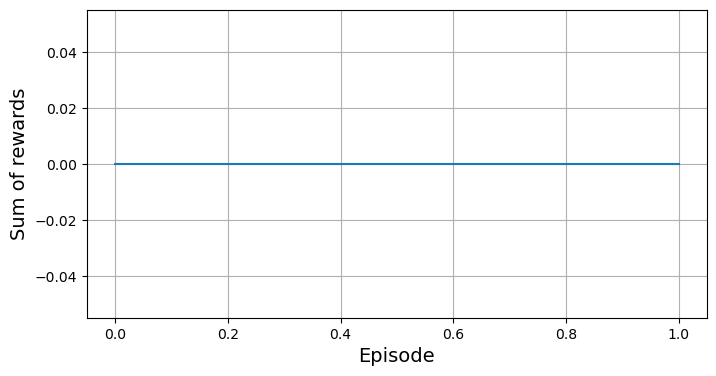

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()